In [2]:
using GraphViz

using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz

In [24]:
# Functions for graphing typed Petri nets
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series
colors_p = ["gold","gold4","darkorange1","lightgoldenrod","goldenrod"] # yellow and orange

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) = 
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_parameter(typed_StockFlow::ACSetTransformation, colors) = 
(p, pp) -> ("p$pp", Attributes(:label=>pname(p,pp) isa Tuple where T ? Html(replace(string(pname(p,pp)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(pname(p,pp))",
                                     :shape=>"circle", 
                                     :color=>colors[typed_StockFlow[:P](pp)],
                                     :fontcolor=>colors[typed_StockFlow[:P](pp)]))

def_auxiliaryVF(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>make_v_expr(p,v) isa Tuple where T ? Html(replace(string(make_v_expr(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(make_v_expr(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:V](v)]))


def_sumV(typed_StockFlow::ACSetTransformation, colors) = 
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)], 
                                       :style=>"filled"))  


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

GraphF_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_p = colors_p, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = GraphF(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryVF(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv), 
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),make_parameter=def_parameter(typed_StockFlow, colors_p),schema=schema, type=type, rd=rd
)

GraphF_typed (generic function with 5 methods)

In [21]:
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"
# SIS_type=StockAndFlowStructure(
#     (:Pop_X=>((:births, :newRecovery, :agingX),(:deathsX, :newInfectious, :agingX),(:v_deathsX, :v_newInfectious, :v_agingX),(:NS,:N)),
#         :Pop_I=>((:newInfectious, :agingI),(:newRecovery,:deathsI, :agingI),(:v_newRecovery,:v_deathsI, :v_agingI),(:NS,:NI,:N))),
#     (:deathsX=>:v_deathsX, :births=>:v_births, :newInfectious=>:v_newInfectious, :newRecovery=>:v_newRecovery,:deathsI=>:v_deathsI,
#      :agingX=>:v_agingX,:agingI=>:v_agingI),
#     (:N=>:v_births, :NI=>:v_newInfectious, :NS=>:v_newInfectious)
# )



sis = @stock_and_flow begin
    :stocks
    X
    I
    
    :parameters
    δ
    μ
    β
    trecovery
    rage
    c
    
    :dynamic_variables
    v_deathsX = X * δ
    v_deathsI = I * δ
    v_births = μ * N
    
    
    v_prevalence = I / N
    v_meanInfectiousContactsPerX = c * v_prevalence
    v_perXIncidenceRate = β * v_meanInfectiousContactsPerX
    v_newInfections = X * v_perXIncidenceRate
    
    v_newRecovery = I / trecovery
    v_agingI = rage * I
    v_agingX = rage * X
    
    :flows
    CLOUD => f_births(v_births) => X
    I => f_newRecovery(v_newRecovery) => X
    X => f_agingX(v_agingX) => X
    X => f_deathsX(v_deathsX) => CLOUD
    X => f_newInfectious(v_newInfections) => I
    I => f_agingI(v_agingI) => I
    I => f_deathsI(v_deathsI) => CLOUD
    
    
    
    
    :sums
    N = [X, I]
    NI = [I]
    NS = [X, I]
    
end

StockAndFlowF with elements S = 1:2, SV = 1:3, LS = 1:5, F = 1:7, I = 1:5, O = 1:6, V = 1:10, LV = 1:7, LSV = 1:2, P = 1:6, LVV = 1:3, LPV = 1:8
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     X │
│ 2 │     I │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NI │
│  3 │     NS │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   1 │    3 │
│  3 │   2 │    1 │
│  4 │   2 │    2 │
│  5 │   2 │    3 │
└────┴─────┴──────┘
┌───┬────┬─────────────────┐
│ F │ fv │           fname │
├───┼────┼─────────────────┤
│ 1 │  3 │        f_births │
│ 2 │  8 │   f_newRecovery │
│ 3 │ 10 │        f_agingX │
│ 4 │  1 │       f_deathsX │
│ 5 │  7 │ f_newInfectious │
│ 6 │  9 │        f_agingI │
│ 7 │  2 │       f_deathsI │
└───┴────┴─────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  1 │
│ 4 │   5 │  2 │
│ 5 │   6 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   3 │  1 │
│ 2 │   4 │  1 │
│ 3 │   5 │  1 │
│ 4 │   2 │  2 │
│ 5 │   6 │  2 │
│ 6 │   7 │  2 │
└───┴─────┴────┘
┌────┬──────────────────────────────┬─────┐
│  V │                        vname │ vop │
├────┼──────────────────────────────┼─────┤
│  1 │                    v_deathsX │   * │
│  2 │                    v_deathsI │   * │
│  3 │                     v_births │   * │
│  4 │                 v_prevalence │   / │
│  5 │ v_meanInfectiousContactsPerX │   * │
│  6 │          v_perXIncidenceRate │   * │
│  7 │              v_newInfections │   * │
│  8 │                v_newRecovery │   / │
│  9 │                     v_agingI │   * │
│ 10 │                     v_agingX │   * │
└────┴──────────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   1 │           1 │
│  2 │   2 │   2 │           1 │
│  3 │   2 │   4 │           1 │
│  4 │   1 │   7 │           1 │
│  5 │   2 │   8 │           1 │
│  6 │   2 │   9 │           2 │
│  7 │   1 │  10 │           2 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    3 │             2 │
│   2 │     1 │    4 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────────┐
│ P │     pname │
├───┼───────────┤
│ 1 │         δ │
│ 2 │         μ │
│ 3 │         β │
│ 4 │ trecovery │
│ 5 │      rage │
│ 6 │         c │
└───┴───────────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     4 │     5 │             2 │
│   2 │     5 │     6 │             2 │
│   3 │     6 │     7 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            2 │
│   2 │    1 │    2 │            2 │
│   3 │    2 │    3 │            1 │
│   4 │    6 │    5 │            1 │
│   5 │    3 │    6 │            1 │
│   6 │    4 │    8 │            2 │
│   7 │    5 │    9 │            1 │
│   8 │    5 │   10 │            1 │
└─────┴──────┴──────┴──────────────┘

In [25]:
Graph_typed(id(sis))

LoadError: UndefVarError: `Graph_typed` not defined

In [19]:
sX, sI = parts(sis, :S)
sv_N, sv_NI, sv_NS = parts(sis, :SV)
lsn_X_N, lsn_X_NS, lsn_I_N, lsn_I_NI, lsn_I_NS = parts(sis, :LS)
f_births, f_newRecovery, f_agingX, f_deathsX, f_newInfectious, f_agingI, f_deathsI = parts(sis, :F)
i_births, i_newRecovery, i_agingX, i_newInfectious, i_agingI = parts(sis, :I)
o_agingX, o_deathsX, o_newInfectious, o_newRecovery, o_agingI, o_deathsI = parts(sis, :O)
v_deathsX, v_deathsI, v_births, v_prevalence, v_meanInfectiousContactsPerX, v_perXIncidenceRate, v_newInfections, v_newRecovery, v_agingI, v_agingX = parts(sis, :V)
lv_deathsX, lv_deathsI, lv_prevalence, lv_newInfections, lv_newRecovery, lv_agingI, lv_agingX = parts(sis, :LV)
lsv_N_births, v_prevalence = parts(sis, :LSV)
δ, μ, β, trecovery, rage, c = parts(sis, :P)
lpv_deathsX, lpv_deathsI, lpv_births, lpv_meanInfectiousContactsPerX, lpv_perXIncidenceRate, lpv_newRecovery, lpv_agingI, lpv_agingX = parts(sis, :LPV)

1:8

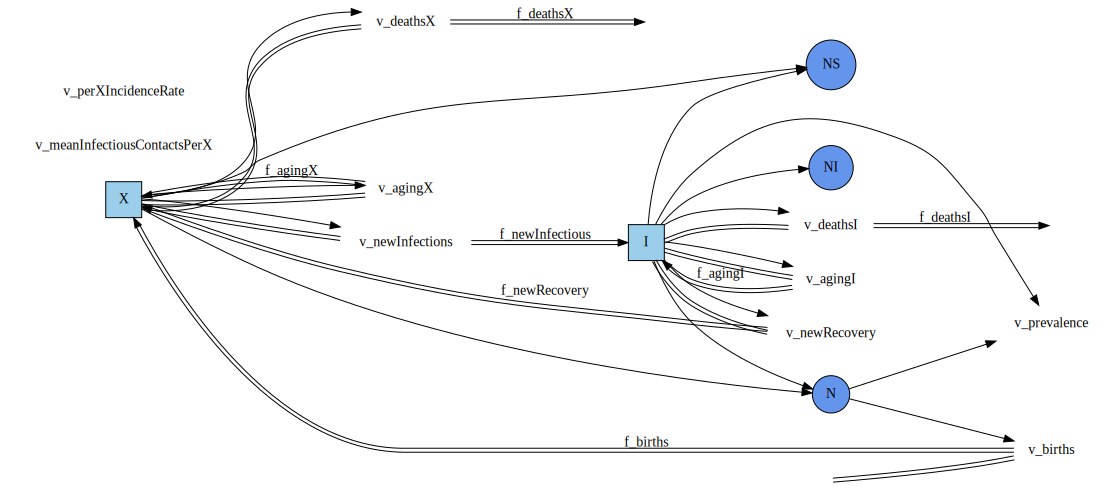

In [22]:
Graph(sis)

In [23]:
sis = map(sis,  Name = name -> nothing, Op=op->nothing, Position=pos->nothing);

In [6]:
WeightModel = @stock_and_flow begin
    :stocks
    NormalWeight
    OverWeight
    Obese
    
    :parameters
    μ
    δw
    rw
    ro
    δo
    rage
    
    :dynamic_variables
    v_NewBorn = N * μ
    v_DeathNormalWeight = NormalWeight * δw
    v_BecomingOverWeight = NormalWeight * rw
    v_DeathOverWeight = OverWeight * δw
    v_BecomingObese = OverWeight * ro
    v_DeathObese = Obese * δo
    v_idNW = NormalWeight * rage
    v_idOW = OverWeight * rage
    v_idOb = Obese * rage
    
    :flows
    CLOUD => f_NewBorn(v_NewBorn) => NormalWeight
    NormalWeight => f_DeathNormalWeight(v_DeathNormalWeight) => ClOUD
    NormalWeight => f_BecomingOverWeight(v_BecomingOverWeight) => OverWeight
    OverWeight => f_DeathOverWeight(v_DeathOverWeight) => CLOUD
    
    OverWeight => f_BecomingObese(v_BecomingObese) => Obese
    Obese => f_DeathObese(v_DeathObese) => CLOUD
    NormalWeight => f_idNW(v_idNW) => NormalWeight
    OverWeight => f_idOW(v_idOW) => OverWeight
    Obese => f_idOb(v_idOb) => Obese
    
    :sums
    N = [NormalWeight, OverWeight, Obese]
    
end

StockAndFlowF with elements S = 1:3, SV = 1:1, LS = 1:3, F = 1:9, I = 1:6, O = 1:8, V = 1:9, LV = 1:8, LSV = 1:1, P = 1:6, LVV = 1:0, LPV = 1:9
┌───┬──────────────┐
│ S │        sname │
├───┼──────────────┤
│ 1 │ NormalWeight │
│ 2 │   OverWeight │
│ 3 │        Obese │
└───┴──────────────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
└────┴─────┴──────┘
┌───┬────┬──────────────────────┐
│ F │ fv │                fname │
├───┼────┼──────────────────────┤
│ 1 │  1 │            f_NewBorn │
│ 2 │  2 │  f_DeathNormalWeight │
│ 3 │  3 │ f_BecomingOverWeight │
│ 4 │  4 │    f_DeathOverWeight │
│ 5 │  5 │      f_BecomingObese │
│ 6 │  6 │         f_DeathObese │
│ 7 │  7 │               f_idNW │
│ 8 │  8 │               f_idOW │
│ 9 │  9 │               f_idOb │
└───┴────┴──────────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   7 │  1 │
│ 3 │   3 │  2 │
│ 4 │   8 │  2 │
│ 5 │   5 │  3 │
│ 6 │   9 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   3 │  1 │
│ 3 │   7 │  1 │
│ 4 │   4 │  2 │
│ 5 │   5 │  2 │
│ 6 │   8 │  2 │
│ 7 │   6 │  3 │
│ 8 │   9 │  3 │
└───┴─────┴────┘
┌───┬──────────────────────┬─────┐
│ V │                vname │ vop │
├───┼──────────────────────┼─────┤
│ 1 │            v_NewBorn │   * │
│ 2 │  v_DeathNormalWeight │   * │
│ 3 │ v_BecomingOverWeight │   * │
│ 4 │    v_DeathOverWeight │   * │
│ 5 │      v_BecomingObese │   * │
│ 6 │         v_DeathObese │   * │
│ 7 │               v_idNW │   * │
│ 8 │               v_idOW │   * │
│ 9 │               v_idOb │   * │
└───┴──────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   2 │           1 │
│  2 │   1 │   3 │           1 │
│  3 │   2 │   4 │           1 │
│  4 │   2 │   5 │           1 │
│  5 │   3 │   6 │           1 │
│  6 │   1 │   7 │           1 │
│  7 │   2 │   8 │           1 │
│  8 │   3 │   9 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             1 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────┐
│ P │ pname │
├───┼───────┤
│ 1 │     μ │
│ 2 │    δw │
│ 3 │    rw │
│ 4 │    ro │
│ 5 │    δo │
│ 6 │  rage │
└───┴───────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            2 │
│   2 │    2 │    2 │            2 │
│   3 │    3 │    3 │            2 │
│   4 │    2 │    4 │            2 │
│   5 │    4 │    5 │            2 │
│   6 │    5 │    6 │            2 │
│   7 │    6 │    7 │            2 │
│   8 │    6 │    8 │            2 │
│   9 │    6 │    9 │            2 │
└─────┴──────┴──────┴──────────────┘